# FENICS SOLVER
## minimalistic 

In [1]:
# Get the libraries
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# define mesh and define function space
X    = 500  #x-limit
Y    = 500  #y-limit
NX   = 50  #x-steps
NY   = 50  #y-steps

mesh = fn.RectangleMesh(fn.Point(-X, -Y), fn.Point(X, Y), NX, NY)

Poly    = fn.FiniteElement('Lagrange', mesh.ufl_cell(),2)
Real    = fn.FiniteElement('Real', mesh.ufl_cell(), 0)
Elem    = [Poly,Poly,Poly,Real,Real] 
Mixed   = fn.MixedElement(Elem)
V       = fn.FunctionSpace(mesh, Mixed)


In [3]:
Elem

[FiniteElement('Lagrange', triangle, 2),
 FiniteElement('Lagrange', triangle, 2),
 FiniteElement('Lagrange', triangle, 2),
 FiniteElement('Real', triangle, 0),
 FiniteElement('Real', triangle, 0)]

In [4]:
# define potentials and concentrations
u_GND  = fn.Expression('0', degree=2)
u_DD   = fn.Expression('0.025', degree=2)
c_INIT = fn.Expression('0.00001', degree=2)
c_AVG  = fn.Expression('0.00001', degree=2)

# define boundaries
def boundaryGND(x, on_boundary):
    tol=1e-12
    return ((x[1] < -500 + tol) and on_boundary) 
def boundaryHigh(x, on_boundary):
    tol=1e-12
    return (x[1] > 500  - tol) and on_boundary

# set boundary conditions
GammaGND  = fn.DirichletBC(V.sub(0), u_GND, boundaryGND)  # ground potential at straight electrode
GammaHigh = fn.DirichletBC(V.sub(0), u_DD, boundaryHigh)  # high potential at shaped electrode
GammaC_GND0 = fn.DirichletBC(V.sub(0) , c_INIT, boundaryGND)
GammaC_GND1 = fn.DirichletBC(V.sub(1) , c_INIT, boundaryGND) 
GammaC_GND2 = fn.DirichletBC(V.sub(2) , c_INIT, boundaryGND)
bcs=[GammaGND,GammaHigh,GammaC_GND0,GammaC_GND1,GammaC_GND2]


# define problem
UC    = fn.Function(V)
uc    = fn.split(UC)
u, c1, c2, lam1, lam2  = uc[0], uc[1], uc [2], uc[3], uc[4]

VW    = fn.TestFunctions(V)                    
v, w1, w2, mu1, mu2  = VW[0], VW[1], VW[2], VW[3], VW[4]

#create rotation
r = fn.Expression('x[0]', degree=1)

# changing concentrations charges
PoissonLeft     = (fn.dot(r*fn.grad(u), fn.grad(v)))*fn.dx
PoissonRight    = r*c1*v*fn.dx - r*c2*v*fn.dx

NernstPlanck1   = (fn.dot(r*(-fn.grad(c1) - (c1)*fn.grad(u)),fn.grad(w1))*fn.dx)
NernstPlanck2   = (fn.dot(r*(-fn.grad(c2) + (c2)*fn.grad(u)),fn.grad(w2))*fn.dx)

Constraint1     = r*lam1 * w1 * fn.dx + r*((c1) - c_AVG) * mu1 * fn.dx
Constraint2     = r*lam2 * w2 * fn.dx + r*((c2) - c_AVG) * mu2 * fn.dx
PNP_xy          = PoissonLeft - PoissonRight + NernstPlanck1 + NernstPlanck2 + Constraint1 + Constraint2
 

In [5]:
# Compute solution
fn.solve(PNP_xy == 0, UC, bcs) # solve function

In [6]:
%matplotlib notebook
x,y=mesh.coordinates().T
X=x.reshape(NX+1,NY+1)
Y=y.reshape(NX+1,NY+1)

In [7]:
w_xy = np.array([UC(xy) for xy in mesh.coordinates()])
W_xy = w_xy.reshape((NX+1),(NY+1),5)
U_xy = W_xy[:,:,0]
C_xys = W_xy[:,:,1:]

<IPython.core.display.Javascript object>


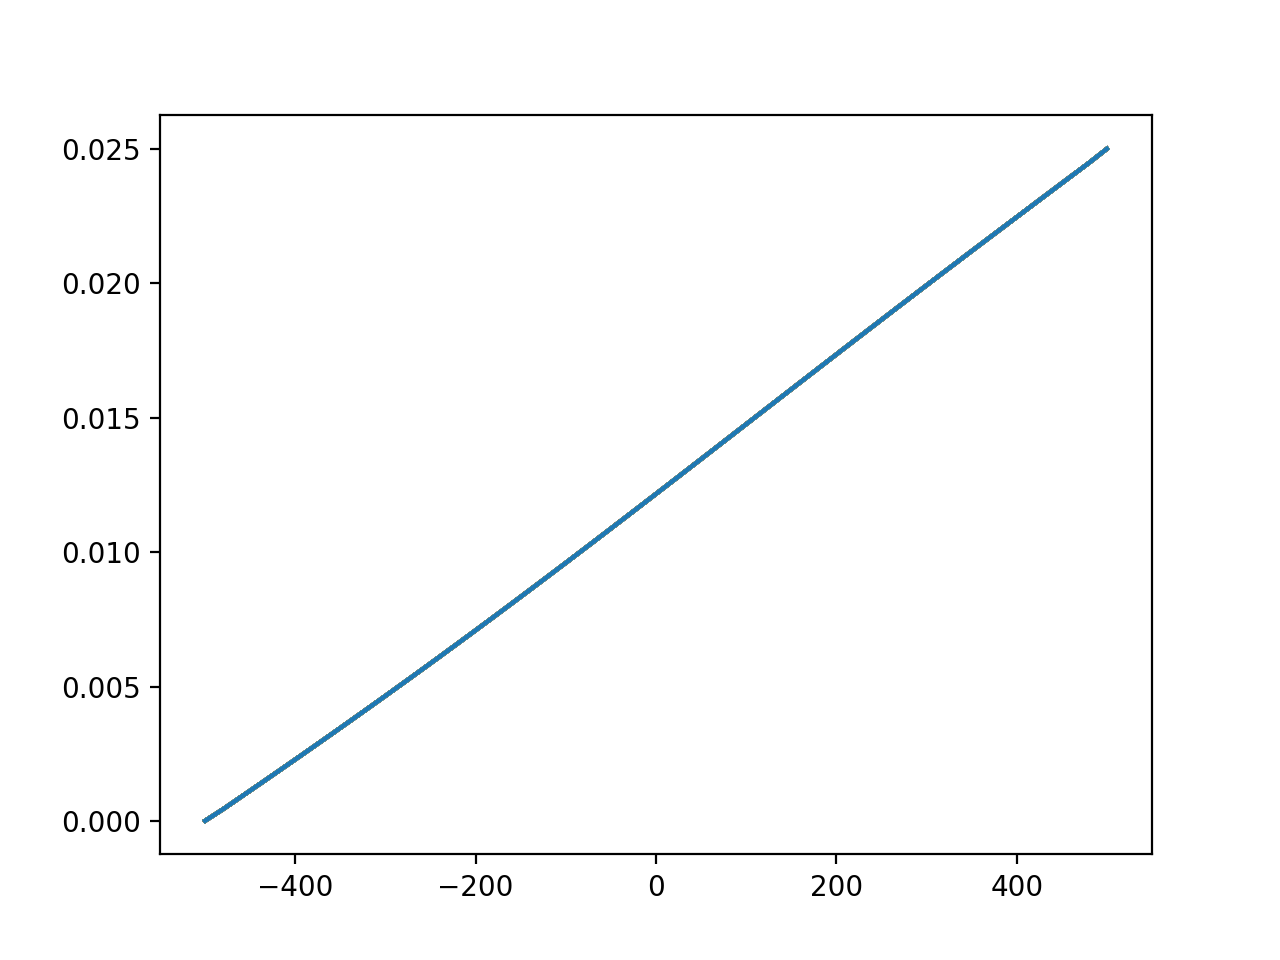

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
#ax.plot(Y,U_xy[::,10])
#ax.plot(Y,U_xy[::,20])
ax.plot(Y,U_xy[::,25])

<IPython.core.display.Javascript object>


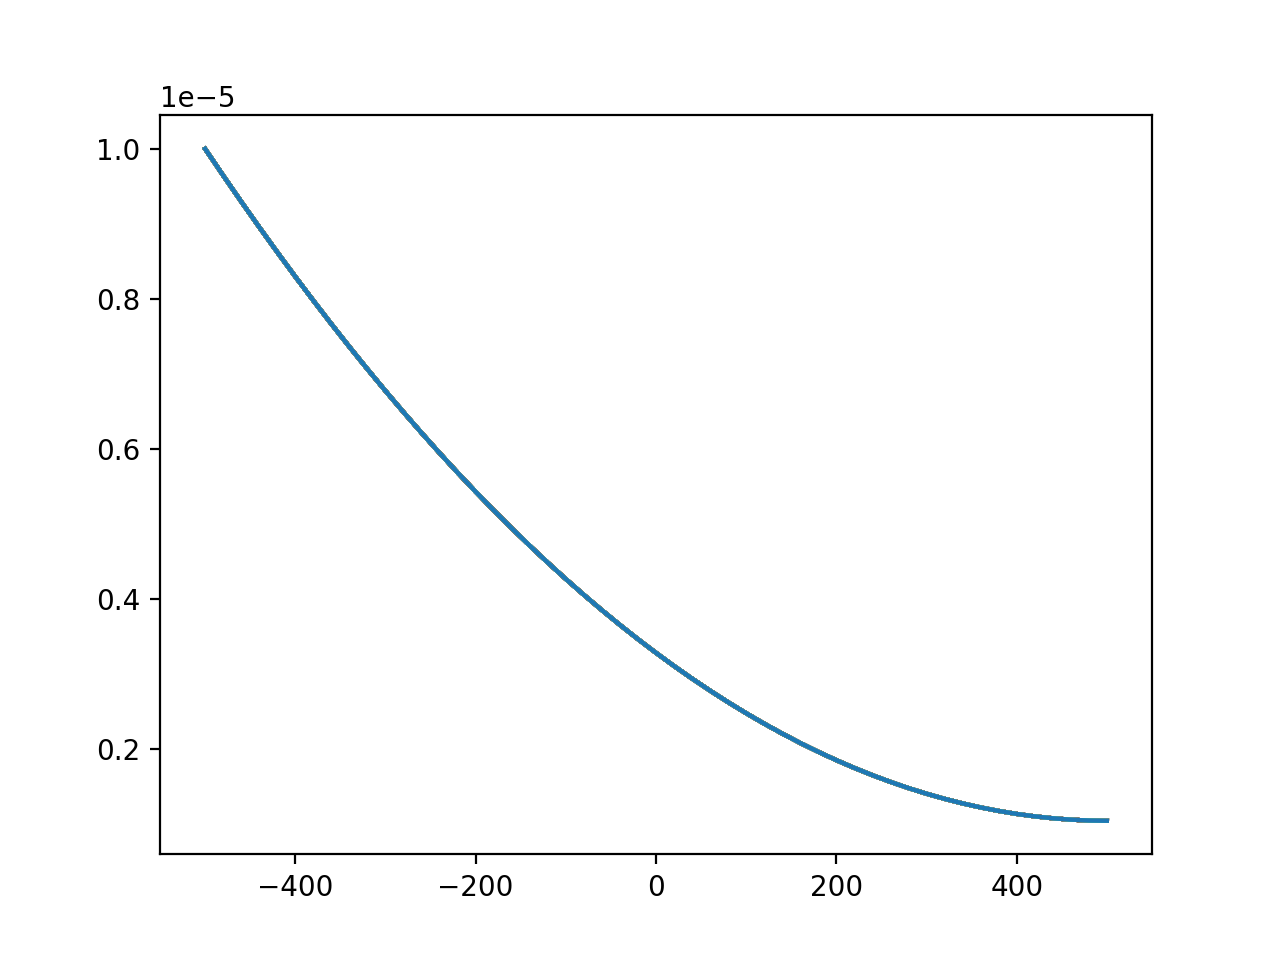

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
#ax.plot(Y,C_xys[:,:,0][::,10])
#ax.plot(Y,C_xys[:,:,0][::,20])
ax.plot(Y,C_xys[:,:,0][::,25])

<IPython.core.display.Javascript object>


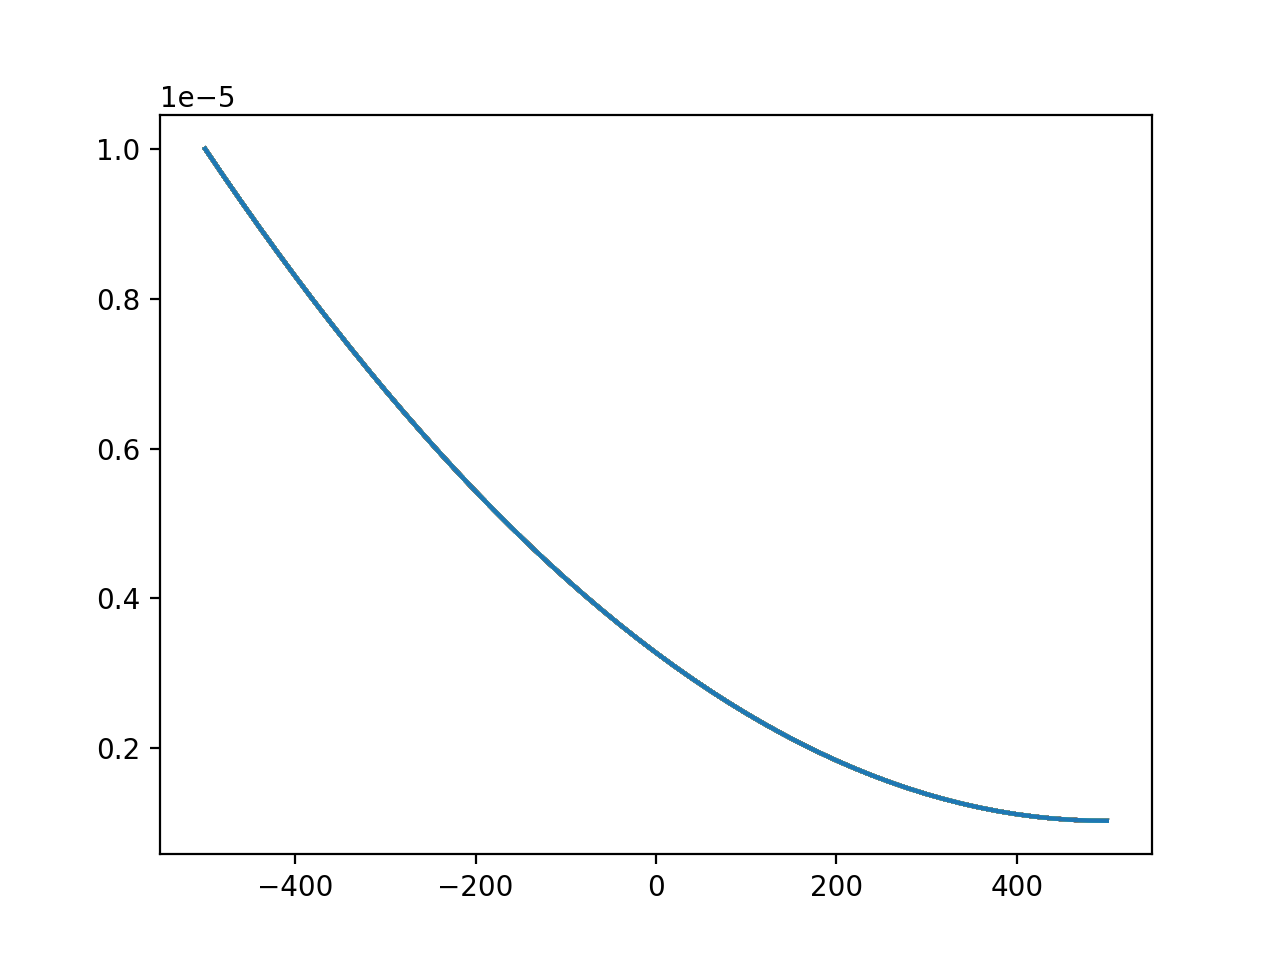

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
#ax.plot(Y,C_xys[:,:,1][::,10])
#ax.plot(Y,C_xys[:,:,1][::,20])
ax.plot(Y,C_xys[:,:,1][::,25])

<IPython.core.display.Javascript object>


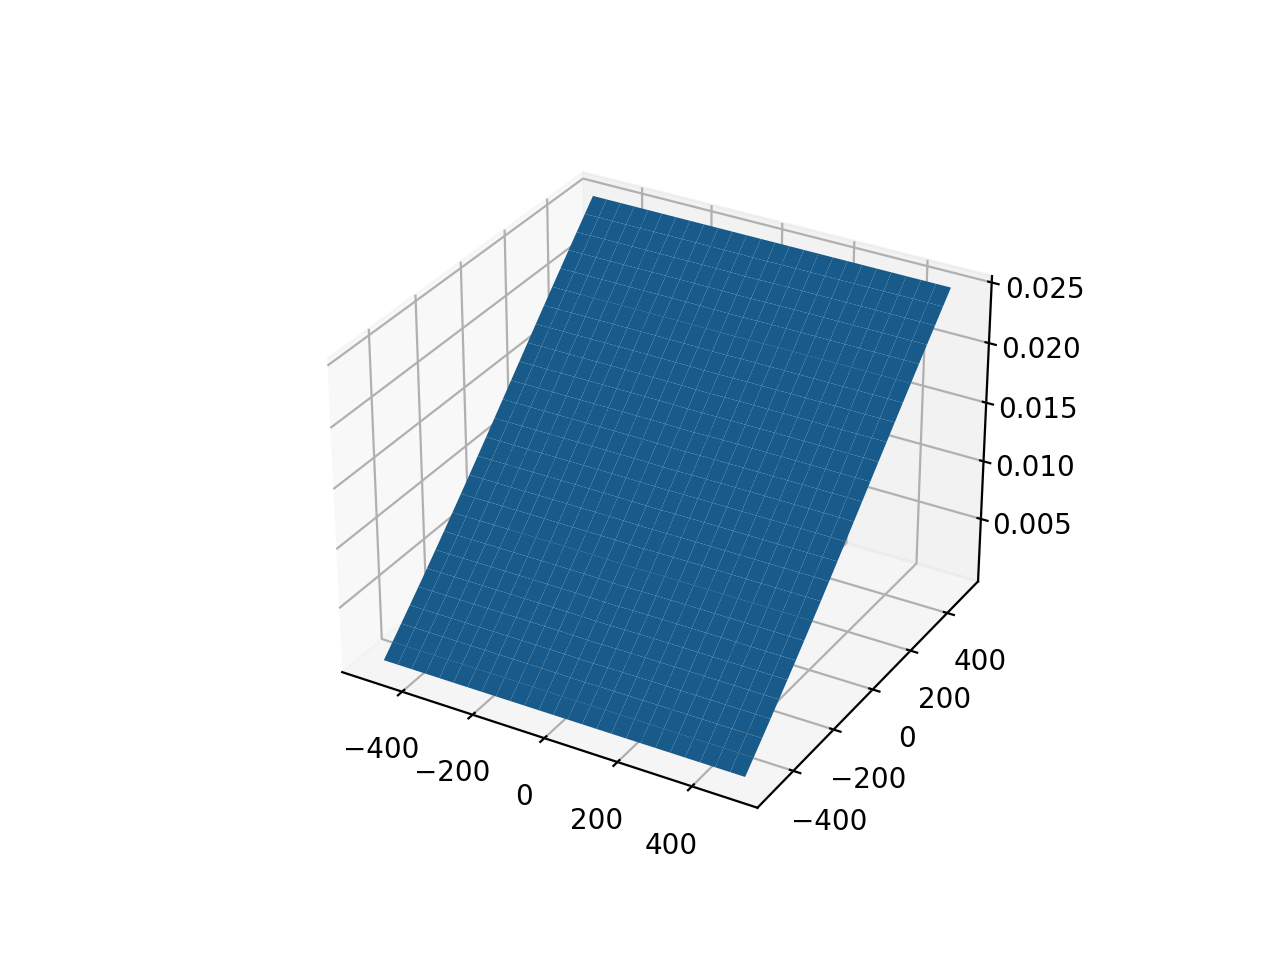

<IPython.core.display.Javascript object>


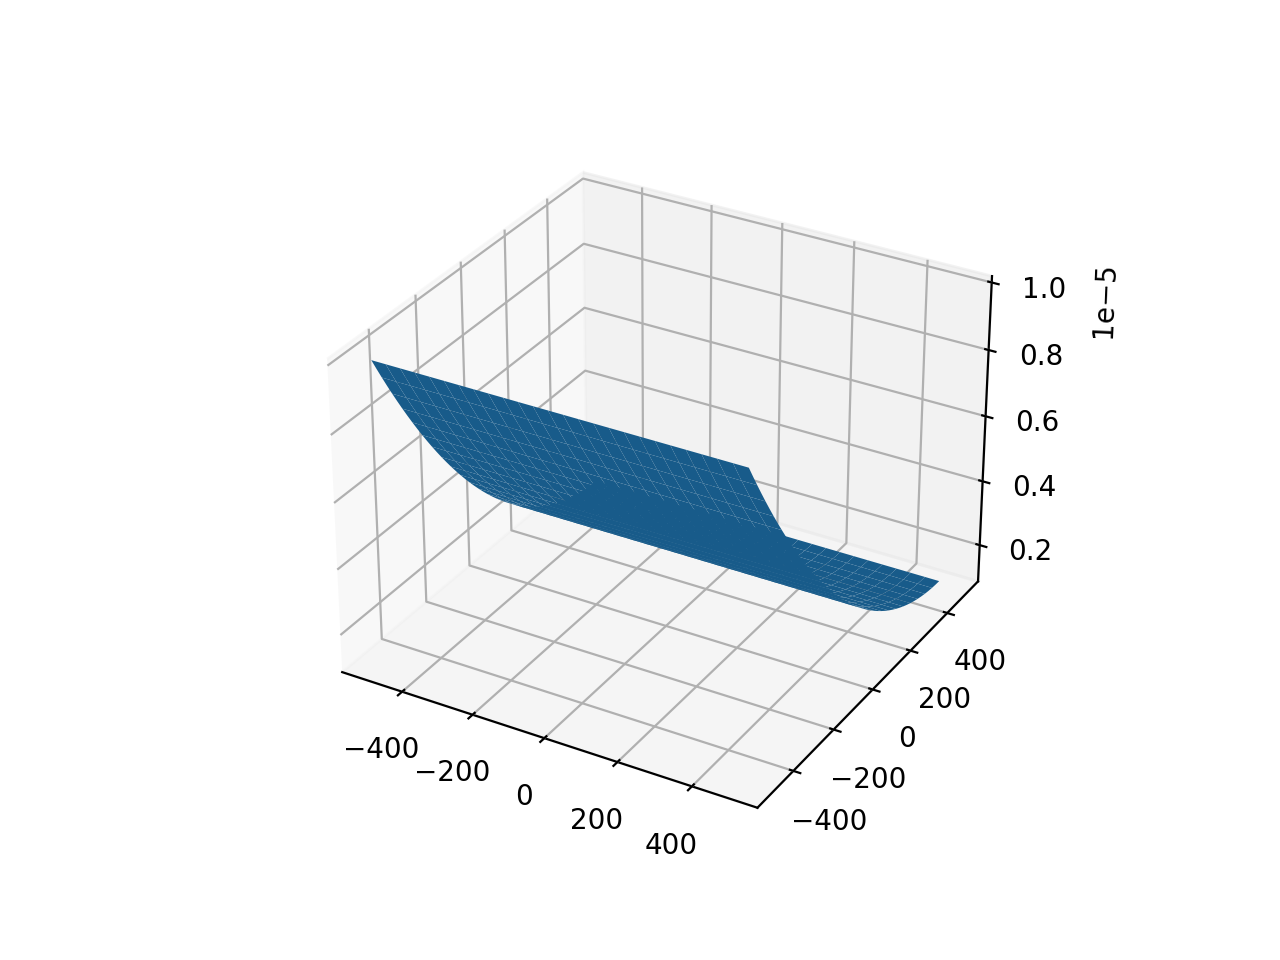

<IPython.core.display.Javascript object>


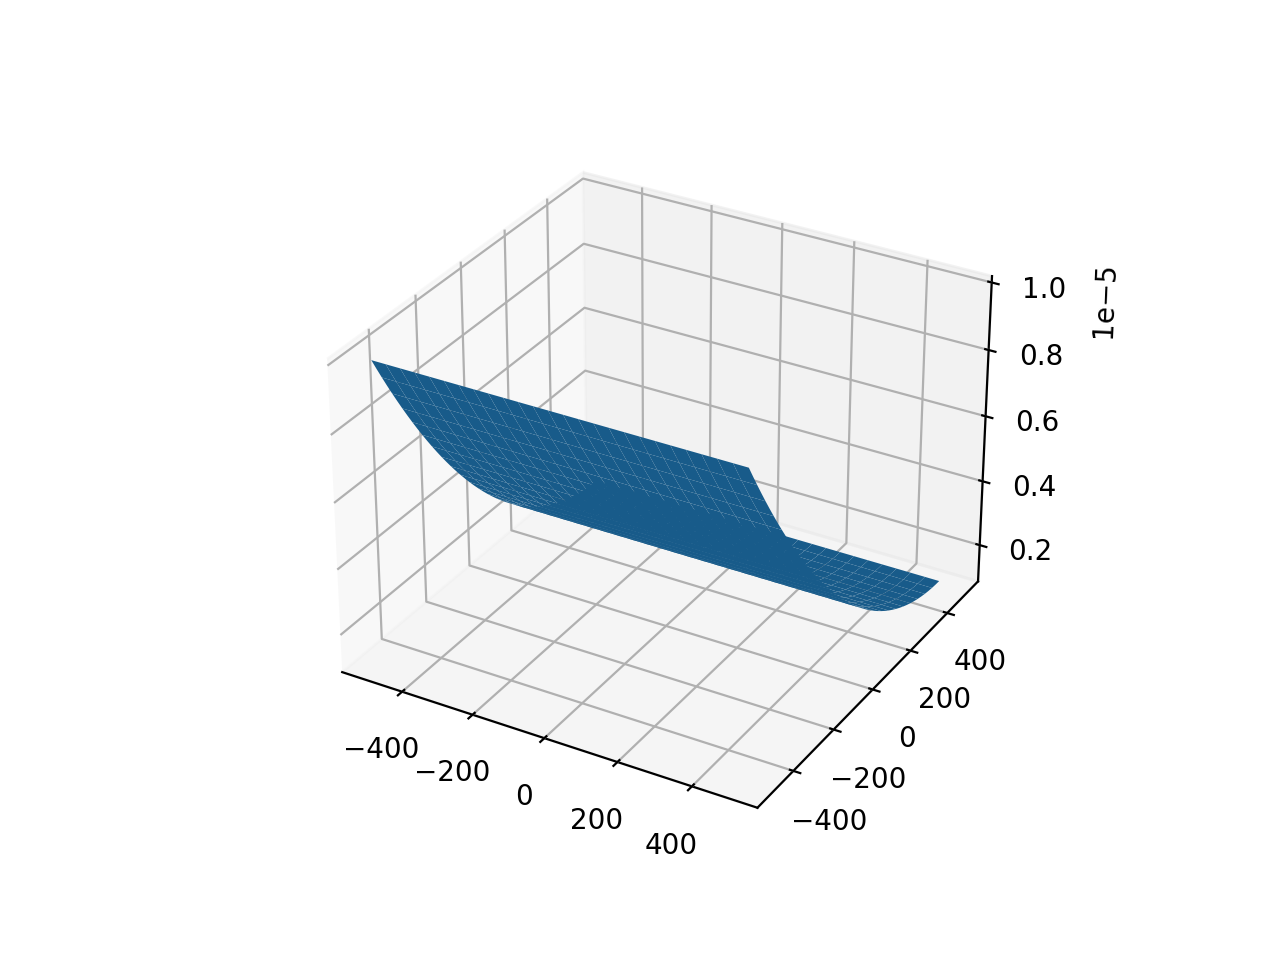

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,U_xy)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,C_xys[:,:,0])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,C_xys[:,:,1])
